# STA/STC Receptive field models for LNP neurons

This notebook demonstrates spike-triggered average (STA) and spike triggered covaraiance (STC) models for neural responses. It uses the output of synthetic, Linear-Nonlinear Poisson (LNP) neurons as a data source.

Inspiration/code from:
1. _"Analysis of Neuronal Spike Trains, Deconstructed"_, by J. Aljadeff, B.J. Lansdell, A.L. Fairhall and D. Kleinfeld (2016) Neuron, 91 http://dx.doi.org/10.1016/j.neuron.2016.05.039 
2. _"Spike-triggered neural characterization"_, by Schwartz, O, Pillow, JW, Rust, NC, and Simoncelli, EP. (2006).  Journal of Vision, 6 [Code](http://pillowlab.princeton.edu/code_STC.html)

_SLH 2017_

In [1]:
import numpy as np
from scipy import linalg,signal

import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab

%matplotlib inline

In [2]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

## Stimuli

Stimuli for this demo are 1) Gaussian white noise $\mathbf{s_g}$, which is a specific example of an "elliptical" distrubution where the STA will yield the best estimate of a linear receptive field, 2) correlated gaussian white noise $\mathbf{s_c}$, which will cause the naive STA to misrepresent the features that best drive the LNP neuron. 

$$
\mathbf{s_g} : \textrm{gaussian white noise stimulus vector} \sim \mathcal{N}(\mu,\,\sigma^{2})\,.
\\
\mu = 1, \sigma^{2} = 1
\\
\mathbf{s_c} : \textrm{correlated gaussian white noise} =  \mathbf{s_g} \ast e^{-t/\tau}
\\
\tau = see\ below
$$

In [3]:
stim_len = 5000000
np.random.seed(14)

# gaussian white noise stimulus
stim_g = np.random.normal(0,1,size=stim_len)

# length of filters + correlation scale, note they are matched so this problem is much easier
nfilt = 30

# exponential filter
te = np.arange(0,nfilt)
tau = np.round(nfilt*.333)
exp_filt = np.exp(-te/(tau))
exp_filt = exp_filt / linalg.norm(exp_filt)

# generate correlated gaussian white noise
stim_c = np.convolve(stim_g,exp_filt)[:stim_len]

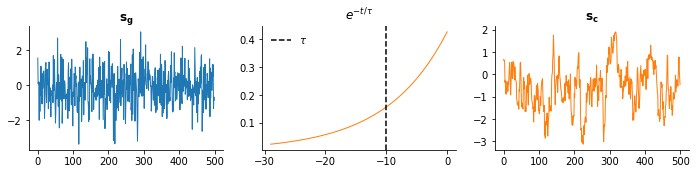

In [4]:
# Inspect signal processing
fig = plt.figure(figsize=(16,5));

ax = plt.subplot(2, 4, 1);
ax.plot(stim_g[:500],lw=1,color='C0');
ax.set_title('$\mathbf{s_g}$');

ax = plt.subplot(2, 4, 2);
ax.plot(-te,exp_filt,lw=1,color='C1');
ax.axvline(-tau,linestyle='--',color='black',label=r'$\tau$');
ax.legend(frameon=False);
ax.set_title(r'$e^{-t/\tau}$');

ax = plt.subplot(2, 4, 3);
ax.plot(stim_c[:500],lw=1,color='C1');
ax.set_title('$\mathbf{s_c}$');

## LNP Cascade

This LNP casecade has two (nonorthogonal) filters and static nonlinearity to define the rate of a poisson process. This is a pretty straighforward model, we want several thousand spikes to recover a good estimate of the feature vectors. The correlated noise will tend to drive more spikes because of our filter widths.

In [5]:
def calc_lnp_output(stim,filt1,filt2,w1=50,w2=50):
    
    # Linear output for each filter
    cf1 = np.convolve(stim,filt1)[:stim_len]
    cf2 = np.convolve(stim,filt2)[:stim_len]
    
    # nonlinearity, with weighted sum
    rate = w1*np.maximum(cf1,0) + w2*np.maximum(cf2,0)
    #rate = w1/10*cf1**2 + w2/10*cf2**2
    
    # Get spiking output, simple method
    spikes = np.random.poisson(rate*tbin)
    
    return (spikes,rate)

In [6]:
# Time resolution for this simulation is miliseconds
tbin = 0.001

tf = np.arange(0,nfilt)

# Filter 1: Simple ingegrating alpha-like function filter
alpha1 = 0.4
filt1 = alpha1 * np.exp(-alpha1*tf) * (alpha1*tf)**4

# Filter 2: Biphasic filter 
alpha2 = 0.75
filt2 = alpha2 * np.exp(-alpha2*tf) * ((alpha2*tf)**5/np.math.factorial(5) - (alpha2*tf)**7/np.math.factorial(7))

# Normalize filters
filt1 = filt1 / linalg.norm(filt1)
filt2 = filt2 / linalg.norm(filt2)

# Weights for each filter
w1 = 20
w2 = 20

# Get spiking output for both stimuli
spikes_g,rate_g = calc_lnp_output(stim_g,filt1,filt2,w1=w1,w2=w2)
spikes_c,rate_c = calc_lnp_output(stim_c,filt1,filt2,w1=w1,w2=w2)

n_spikes_g = np.sum(spikes_g,axis=0)
n_spikes_c = np.sum(spikes_c,axis=0)
print("Gaussian noise: {} spikes\nCorrelated noise: {} spikes".format(n_spikes_g,n_spikes_c))

# weighted sum of filters for comparison with STA
filt_sum = w1*filt1+w2*filt2
filt_sum = filt_sum / linalg.norm(filt_sum)

Gaussian noise: 79659 spikes
Correlated noise: 193779 spikes


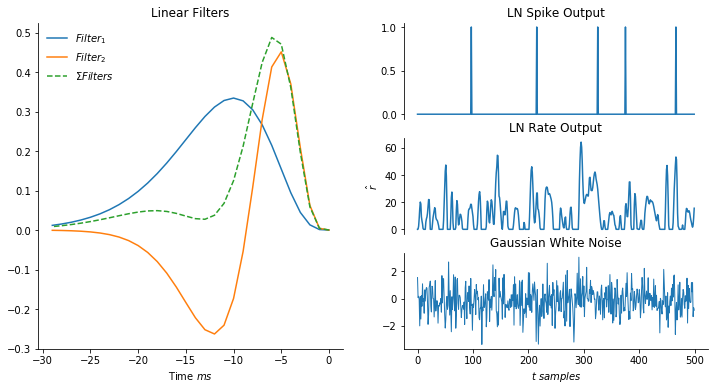

In [7]:
# Inspect LNP Cascade
fig = plt.figure(figsize=(12,6));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,filt1,label='$Filter_1$');
ax1.hold
ax1.plot(-tf,filt2,label='$Filter_2$');
ax1.plot(-tf,filt_sum,label='$\Sigma{} Filters$',linestyle='--');
ax1.legend(frameon=False);
ax1.set_title('Linear Filters');
ax1.set_xlabel('Time $ms$');

# Plot rate output
ax2 = plt.subplot(3, 2, 2);
ax2.plot(spikes_g[:500],color='C0');
ax2.xaxis.set_visible(False);
ax2.spines["bottom"].set_visible(False);
ax2.set_title("LN Spike Output");

ax2 = plt.subplot(3, 2, 4);
ax2.plot(rate_g[:500],color='C0');
ax2.xaxis.set_visible(False);
ax2.spines["bottom"].set_visible(False);
ax2.set_title("LN Rate Output");
ax2.set_ylabel(r"$\hat{r}$");

ax2 = plt.subplot(3, 2, 6);
ax2.plot(stim_g[:500],lw=1,color='C0');
ax2.set_title("Gaussian White Noise");
ax2.set_xlabel(r"$t\ samples$");

## STA +/- whitening

Simple calculation of the spike-triggered average, accounting for stimulus correlations if whitened.

It is very easy to calculate the STA and whitened STA using the design matrix from regression analysis (see J Pillow's GLM demo). In this case it is just several copies of the stimulus shifted different amounts in time (with zero padding) in each in a column. It is easier to look at the matrix below to see why this is useful...

In [8]:
def make_design_mat(stim,nfilt):
    pad = np.zeros(nfilt-1)
    pad_stim = np.concatenate((pad,stim))    
    design_mat = linalg.hankel(c=pad_stim[0:1-nfilt],r=stim[-nfilt:])

    return design_mat

In [9]:
# Make design matricies
d_mat_g = make_design_mat(stim_g,nfilt=nfilt)
d_mat_c = make_design_mat(stim_c,nfilt=nfilt)

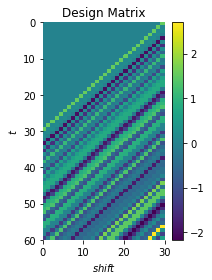

In [10]:
plt.figure(figsize=(6,4))
ax = plt.subplot(1, 2, 1);
pylab.pcolormesh(d_mat_g[0:nfilt*2,:]);
pylab.colorbar();
ax.invert_yaxis();
ax.set_title('Design Matrix');
ax.set_ylabel(r"$t$");
ax.set_xlabel(r"$shift$");
ax.spines["left"].set_visible(False);
ax.spines["bottom"].set_visible(False);

In [11]:
# Calculate STA in one line!
sta_g = np.dot(d_mat_g.T,spikes_g) / n_spikes_g
sta_g = sta_g / linalg.norm(sta_g)

sta_c = np.dot(d_mat_c.T,spikes_c) / n_spikes_c
sta_c = sta_c / linalg.norm(sta_c)

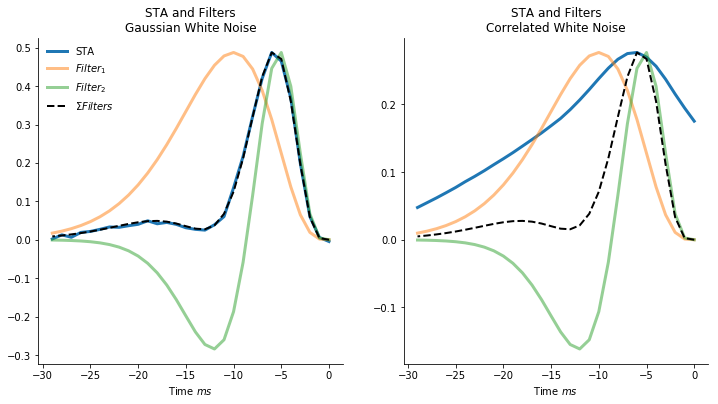

In [12]:
# Look at naive filters and STAs
fig = plt.figure(figsize=(12,6));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,sta_g[::-1],label='STA',lw=3,color='C0');
ax1.hold;
ax1.plot(-tf,filt1/np.max(filt1)*np.max(sta_g),label='$Filter_1$',lw=3,alpha=.5,color='C1');
ax1.plot(-tf,filt2/np.max(filt2)*np.max(sta_g),label='$Filter_2$',lw=3,alpha=.5,color='C2');
ax1.plot(-tf,filt_sum/np.max(filt_sum)*np.max(sta_g),label='$\Sigma{} Filters$',linestyle='--',lw=2,alpha=1,color='k');
ax1.legend(frameon=False);
ax1.set_title('STA and Filters\nGaussian White Noise');
ax1.set_xlabel('Time $ms$');

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 2);
ax1.plot(-tf,sta_c[::-1],label='STA',lw=3,color='C0');
ax1.hold;
ax1.plot(-tf,filt1/np.max(filt1)*np.max(sta_c),label='$Filter_1$',lw=3,alpha=.5,color='C1');
ax1.plot(-tf,filt2/np.max(filt2)*np.max(sta_c),label='$Filter_2$',lw=3,alpha=.5,color='C2');
ax1.plot(-tf,filt_sum/np.max(filt_sum)*np.max(sta_c),label='$\Sigma{} Filters$',linestyle='--',lw=2,alpha=1,color='k');
ax1.set_title('STA and Filters\nCorrelated White Noise');
ax1.set_xlabel('Time $ms$');

In [58]:
def calc_cov_mat(design_mat,spikes=None):
    """
    Calculate the stimulus covariance matrix from design matrix
    optionally make it spike triggered. 
    
    This is the "zero-centered" method described by Aljadeff et al 2013
    where the covariance difference matrix is diagonalized.
    
    spikes must have the same number of entries as design matrix has rows
    """
    if spikes is None:
        mu = np.mean(design_mat,axis=0)
        D = design_mat - mu
    else:
        mu = np.dot(design_mat.T,spikes)
        D = design_mat[spikes > 0] - mu

    C = np.cov(D.T,bias=False)
    
    return(C,mu)

In [59]:
# Caclulate the stimulus covariance matricies
Cg = calc_cov_mat(d_mat_g)[0]
Cc = calc_cov_mat(d_mat_c)[0]

# Normalize the STA by covariance matrix
#ridge = .5
#C_inv = linalg.inv(C + ridge*np.eye(C.shape[0]))
# Regularize the inverse matrix...
rcond=.025
Cc_inv,rank = linalg.pinv(Cc,rcond=rcond,return_rank=True)

w_sta_g = np.dot(Cc_inv.T,sta_g)
w_sta_g = w_sta_g / linalg.norm(w_sta_g)

print("Rank of pseudoinverse matrix : {}".format(rank))

Rank of pseudoinverse matrix : 8


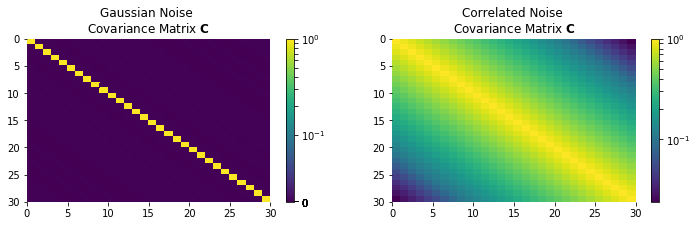

In [60]:
# Look at correlations in time
fig = plt.figure(figsize=(12,3));
for i,(X,desc) in enumerate(zip([Cg,Cc],['Gaussian','Correlated'])):
    ax = plt.subplot(1, 2, 1+i);
    pylab.pcolormesh(X,norm=mpl.colors.SymLogNorm(vmin=X.min(),vmax=X.max(),linthresh=0.1));
    pylab.colorbar()
    ax.spines["left"].set_visible(False);
    ax.spines["bottom"].set_visible(False);
    ax.invert_yaxis();
    ax.set_title(desc + ' Noise \nCovariance Matrix $\mathbf{C}$');

In [61]:
Uc,sc = linalg.svd(Cc)[0:2]

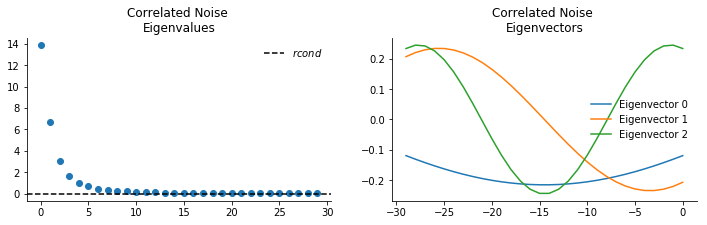

In [62]:
fig = plt.figure(figsize=(12,3));

# Plot eigenvalues
ax1 = plt.subplot(1, 2, 1);
ax1.plot(sc,'o');
ax1.hold;
ax1.axhline(rcond,linestyle='--',color='black',label=r'$rcond$');
ax1.set_title('Correlated Noise \nEigenvalues');
ax1.legend(frameon=False);

# Plot eigenvectors
ax2 = plt.subplot(1, 2, 2);
for i in range(3):
    ax2.plot(-tf,Uc[:,i],'-',label="Eigenvector " + str(i));
    ax2.hold;
ax2.set_title('Correlated Noise \nEigenvectors');
ax2.legend(frameon=False);

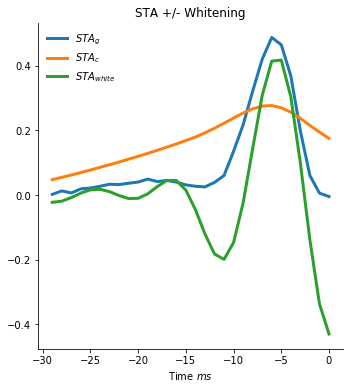

In [288]:
fig = plt.figure(figsize=(12,6));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,sta_g[::-1],label='$STA_{g}$',lw=3,color='C0');
ax1.hold
ax1.plot(-tf,sta_c[::-1],label='$STA_{c}$',lw=3,color='C1');
ax1.plot(-tf,w_sta_g[::-1],label='$STA_{white}$',lw=3,color='C2');
ax1.legend(frameon=False);
ax1.set_title('STA +/- Whitening');
ax1.set_xlabel('Time $ms$');

In [ ]:
# Calculate the spiking nonlinearity



## STC +/- whitening

Calculate the spike-triggered covariance of the stimulus. Test regularization on the matrix inversion too e.g. `np.pinv()`.

In [81]:
Cg_st,sta_g2 = calc_cov_mat(d_mat_g,spikes_g)
Cg_diff = Cg_st-Cg

Cc_st,sta_c2 = calc_cov_mat(d_mat_c,spikes_c)
Cc_diff = Cc_st-Cc

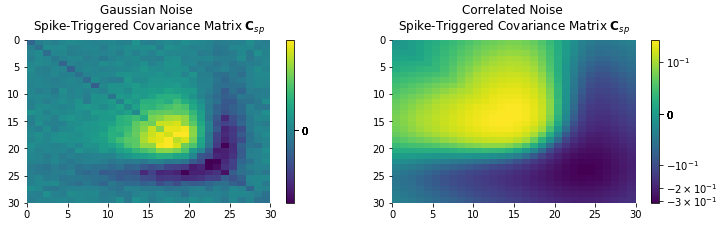

In [84]:
fig = plt.figure(figsize=(12,3));
for i,(X,desc) in enumerate(zip([Cg_diff,Cc_diff],['Gaussian','Correlated'])):
    ax = plt.subplot(1, 2, 1+i);
    pylab.pcolormesh(X,norm=mpl.colors.SymLogNorm(vmin=X.min(),vmax=X.max(),linthresh=0.1));
    pylab.colorbar();
    ax.spines["left"].set_visible(False);
    ax.spines["bottom"].set_visible(False);
    ax.invert_yaxis();
    ax.set_title(desc + ' Noise \nSpike-Triggered Covariance Matrix $\mathbf{C}_{sp}$');

In [101]:
# Diagonalize both of the difference matricies
Ug_st,sg_st = linalg.svd(Cg_diff)[:-1]
Uc_st,sc_st = linalg.svd(Cc_diff)[:-1]

In [147]:
# Use random matrix for significantce on white distrubuted stimulus


In [275]:
# Bootstrap for eigenvalue significance on non-white stimulus
nreps = 1000
s_rand = []
nsamps = spikes_c.shape[0]
for i in range(nreps):
    
    # Preserve spike train structure
    #shift = np.random.randint(0,high=nsamps)
    #shift_inds = np.mod(shift + np.arange(0,nsamps),nsamps)
    #rand_spikes = spikes_c.copy()
    #rand_spikes = rand_spikes[shift_inds]
    
    # Completely new spike locations
    rand_spikes = np.zeros_like(spikes_c)
    rand_spikes[np.random.randint(0,nsamps,size=n_spikes_c)] = 1
    
    Cr = calc_cov_mat(d_mat_c,rand_spikes)[0]
    # Lower resource use here than expected, nice!
    s_rand.append(linalg.svd(Cr - Cc,compute_uv=False))
    
s_rand = np.array(s_rand)
sig_bounds = np.percentile(s_rand,q=[0,100])

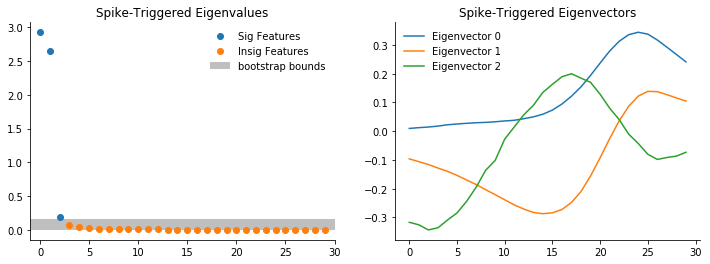

In [287]:
fig = plt.figure(figsize=(12,4));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
sigs_inds = (sc_st < sig_bounds[0]) | (sc_st > sig_bounds[1]);
ax1.fill_between(np.arange(-2,33),sig_bounds[0],sig_bounds[1],alpha=0.5,facecolor='gray',label='bootstrap bounds');
ax1.hold;
ax1.plot(np.where(sigs_inds)[0],sc_st[sigs_inds],'o',color='C0',label='Sig Features');
ax1.plot(np.where(~sigs_inds)[0],sc_st[~sigs_inds],'o',color='C1',label='Insig Features');
ax1.set_xlim(-1,30)
#ax1.axhline(sig_bounds[0],linestyle='--',alpha=.5,color='black',label=r'$rcond$');
#ax1.axhline(sig_bounds[1],linestyle='--',alpha=.5,color='black',label=r'$rcond$');
ax1.set_title('Spike-Triggered Eigenvalues');
ax1.legend(frameon=False);

ax2 = plt.subplot(1, 2, 2);
for i in [0,1,2]:
    ax2.plot(tf,Uc_st[:,i],'-',label="Eigenvector " + str(i));
    ax2.hold;
ax2.set_title('Spike-Triggered Eigenvectors');
ax2.legend(frameon=False);

In [ ]:
# Calculate the spiking nonlinearity



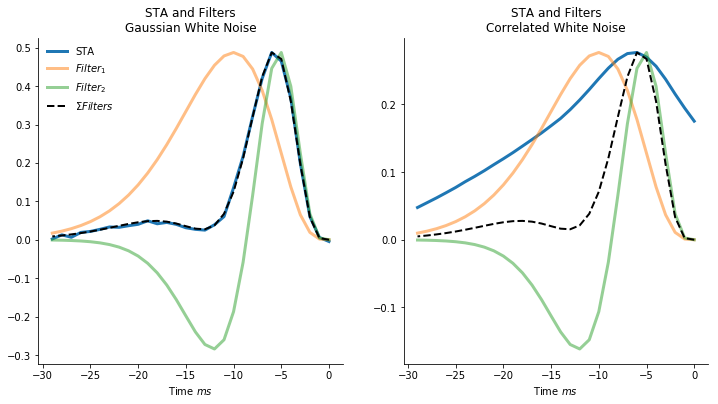

In [278]:
# Look at naive filters
fig = plt.figure(figsize=(12,6));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,sta_g[::-1],label='STA',lw=3,color='C0');
ax1.hold;
ax1.plot(-tf,filt1/np.max(filt1)*np.max(sta_g),label='$Filter_1$',lw=3,alpha=.5,color='C1');
ax1.plot(-tf,filt2/np.max(filt2)*np.max(sta_g),label='$Filter_2$',lw=3,alpha=.5,color='C2');
ax1.plot(-tf,filt_sum/np.max(filt_sum)*np.max(sta_g),label='$\Sigma{} Filters$',linestyle='--',lw=2,alpha=1,color='k');
ax1.legend(frameon=False);
ax1.set_title('STA and Filters\nGaussian White Noise');
ax1.set_xlabel('Time $ms$');

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 2);
ax1.plot(-tf,sta_c[::-1],label='STA',lw=3,color='C0');
ax1.hold;
ax1.plot(-tf,filt1/np.max(filt1)*np.max(sta_c),label='$Filter_1$',lw=3,alpha=.5,color='C1');
ax1.plot(-tf,filt2/np.max(filt2)*np.max(sta_c),label='$Filter_2$',lw=3,alpha=.5,color='C2');
ax1.plot(-tf,filt_sum/np.max(filt_sum)*np.max(sta_c),label='$\Sigma{} Filters$',linestyle='--',lw=2,alpha=1,color='k');
ax1.set_title('STA and Filters\nCorrelated White Noise');
ax1.set_xlabel('Time $ms$');